# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

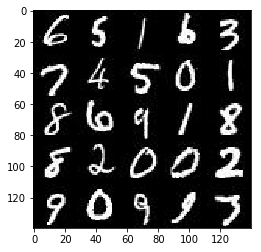

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

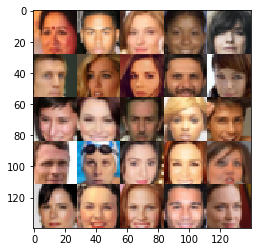

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image = tf.placeholder(tf.float32,[None, image_width, image_height, image_channels],name='input_real')
    Z = tf.placeholder(tf.float32, [None, z_dim],name='input_z')
    l_rate = tf.placeholder(tf.float32)

    return image, Z, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [55]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        images = tf.layers.dropout(images, rate=0.4)
        # input image is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=1,padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.layers.dropout(relu1, rate=0.4)
        # 28*28*64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.layers.dropout(relu2, rate=0.4)
        # 14*14*256
         
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same',
                             kernel_initializer = tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=0.4)
        # 7*7*256
               
        # dropout
        dropout = tf.nn.dropout(relu3, 0.4)
        
        #leaky Relu
        flat = tf.reshape(dropout, (-1, 7*7*256))
        logits = tf.layers.dense(flat,1,activation=None)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [56]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
               
        x4 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        # 14x14x256
        
        x5 = tf.layers.conv2d_transpose(x4, 64, 5, strides=1, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        # 14x14x128
        

        # Output layer
        logits = tf.layers.conv2d_transpose(x5, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        
        out = tf.tanh(logits)
        
        return out 
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [57]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    # Smoothing 
    smooth = 0.8
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)) * (1 - smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [58]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [60]:
import sklearn.preprocessing
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    class GAN:
        def __init__(self, data_shape, z_dim, learning_rate):
        
            self.input_real, self.input_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              data_shape[3])
        
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
    

    net = GAN(data_shape, z_dim, learning_rate)

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                #print(batch_images.shape)
                
                # normalize
                bachr_images = batch_images*2
                    
                
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    

                if steps % 100 == 0:
                    show_generator_output(sess, 25, net.input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.8087... Generator Loss: 0.3792
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 1.5715
Epoch 1/2... Discriminator Loss: 2.3474... Generator Loss: 0.4515
Epoch 1/2... Discriminator Loss: 1.8443... Generator Loss: 0.3828
Epoch 1/2... Discriminator Loss: 1.6418... Generator Loss: 0.4660
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 1.5054
Epoch 1/2... Discriminator Loss: 1.4651... Generator Loss: 2.8470
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.3690
Epoch 1/2... Discriminator Loss: 1.0209... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 0.7644... Generator Loss: 1.4716


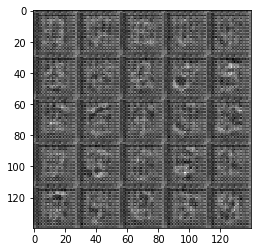

Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 0.6790
Epoch 1/2... Discriminator Loss: 0.9400... Generator Loss: 0.6864
Epoch 1/2... Discriminator Loss: 0.5029... Generator Loss: 1.7527
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 1.6373
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 0.5717
Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 0.4300
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.5334
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.8183
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 0.5903
Epoch 1/2... Discriminator Loss: 1.7808... Generator Loss: 0.2239


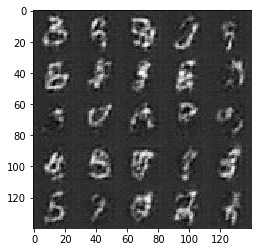

Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 1.3315
Epoch 1/2... Discriminator Loss: 0.3252... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 0.2601... Generator Loss: 2.1446
Epoch 1/2... Discriminator Loss: 4.7208... Generator Loss: 8.0958
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 0.9482... Generator Loss: 0.6287
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 0.9441
Epoch 1/2... Discriminator Loss: 1.9102... Generator Loss: 0.2440
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.5786
Epoch 1/2... Discriminator Loss: 0.5258... Generator Loss: 1.3870


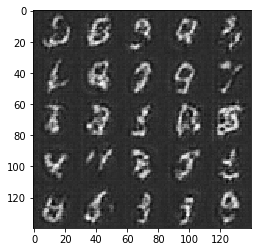

Epoch 1/2... Discriminator Loss: 0.4598... Generator Loss: 3.0903
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.1006
Epoch 1/2... Discriminator Loss: 1.3098... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 0.9603... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 0.7456... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 0.6632... Generator Loss: 1.3067
Epoch 1/2... Discriminator Loss: 0.5391... Generator Loss: 1.1243
Epoch 1/2... Discriminator Loss: 0.3972... Generator Loss: 1.4957
Epoch 1/2... Discriminator Loss: 0.6244... Generator Loss: 1.0468
Epoch 1/2... Discriminator Loss: 0.1711... Generator Loss: 2.4255


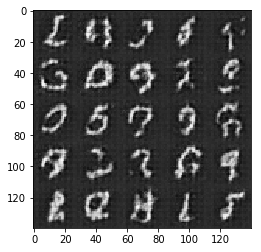

Epoch 1/2... Discriminator Loss: 0.2892... Generator Loss: 1.9239
Epoch 1/2... Discriminator Loss: 2.5580... Generator Loss: 6.0150
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 0.8205... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.3785
Epoch 1/2... Discriminator Loss: 0.4408... Generator Loss: 2.4768
Epoch 1/2... Discriminator Loss: 0.2823... Generator Loss: 2.6252
Epoch 1/2... Discriminator Loss: 0.2852... Generator Loss: 1.9021
Epoch 1/2... Discriminator Loss: 0.1030... Generator Loss: 4.6782
Epoch 1/2... Discriminator Loss: 0.6746... Generator Loss: 1.2235


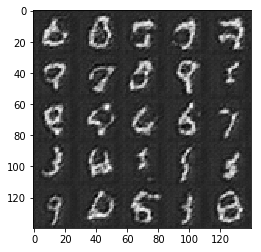

Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 1.1085
Epoch 1/2... Discriminator Loss: 0.5646... Generator Loss: 1.1779
Epoch 1/2... Discriminator Loss: 0.8003... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 0.3566... Generator Loss: 1.6416
Epoch 1/2... Discriminator Loss: 0.2386... Generator Loss: 1.9981
Epoch 1/2... Discriminator Loss: 0.3660... Generator Loss: 1.5338
Epoch 1/2... Discriminator Loss: 3.3638... Generator Loss: 0.0545
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.7004


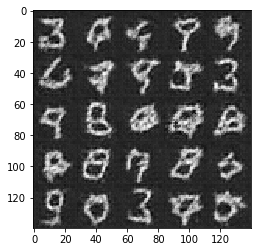

Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 2.0891
Epoch 1/2... Discriminator Loss: 0.5478... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 0.6086... Generator Loss: 1.2286
Epoch 1/2... Discriminator Loss: 0.2731... Generator Loss: 1.9925
Epoch 1/2... Discriminator Loss: 0.1849... Generator Loss: 3.8385
Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 0.3876
Epoch 1/2... Discriminator Loss: 0.6595... Generator Loss: 1.7444
Epoch 1/2... Discriminator Loss: 0.6299... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 0.4656... Generator Loss: 1.2401


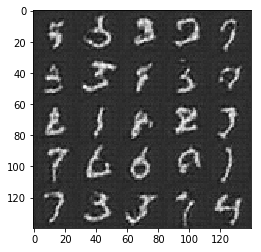

Epoch 1/2... Discriminator Loss: 0.8198... Generator Loss: 5.8596
Epoch 1/2... Discriminator Loss: 0.4505... Generator Loss: 1.2112
Epoch 1/2... Discriminator Loss: 0.4334... Generator Loss: 1.4263
Epoch 1/2... Discriminator Loss: 0.0869... Generator Loss: 3.8456
Epoch 1/2... Discriminator Loss: 2.2785... Generator Loss: 5.4750
Epoch 1/2... Discriminator Loss: 0.8194... Generator Loss: 1.2313
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 1.8299
Epoch 1/2... Discriminator Loss: 1.6357... Generator Loss: 5.1255
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.3820
Epoch 1/2... Discriminator Loss: 0.2814... Generator Loss: 1.6707


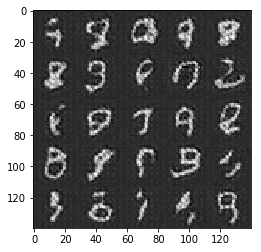

Epoch 1/2... Discriminator Loss: 0.3828... Generator Loss: 1.5077
Epoch 1/2... Discriminator Loss: 0.0430... Generator Loss: 4.5793
Epoch 1/2... Discriminator Loss: 1.1113... Generator Loss: 7.3756
Epoch 1/2... Discriminator Loss: 0.6872... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 1.6699... Generator Loss: 4.1229
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 1.4407
Epoch 1/2... Discriminator Loss: 0.6084... Generator Loss: 1.0564
Epoch 1/2... Discriminator Loss: 0.5651... Generator Loss: 1.1527
Epoch 1/2... Discriminator Loss: 0.7692... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 1.4231


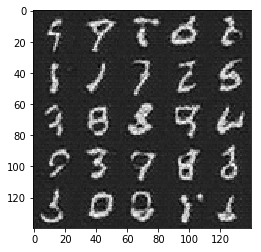

Epoch 1/2... Discriminator Loss: 0.4173... Generator Loss: 1.4078
Epoch 1/2... Discriminator Loss: 0.4514... Generator Loss: 1.8007
Epoch 1/2... Discriminator Loss: 0.1017... Generator Loss: 3.1880
Epoch 2/2... Discriminator Loss: 0.3199... Generator Loss: 1.6676
Epoch 2/2... Discriminator Loss: 0.2463... Generator Loss: 1.9974
Epoch 2/2... Discriminator Loss: 0.2393... Generator Loss: 1.8165
Epoch 2/2... Discriminator Loss: 0.0859... Generator Loss: 7.4864
Epoch 2/2... Discriminator Loss: 1.1688... Generator Loss: 0.5877
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.6429
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 0.9798


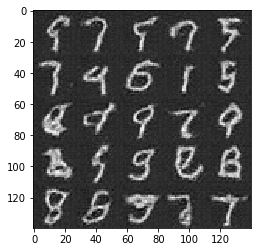

Epoch 2/2... Discriminator Loss: 0.9990... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 3.8855
Epoch 2/2... Discriminator Loss: 1.5167... Generator Loss: 4.7592
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 0.6978
Epoch 2/2... Discriminator Loss: 0.6569... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 1.0146... Generator Loss: 0.6984
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.5743
Epoch 2/2... Discriminator Loss: 0.1914... Generator Loss: 3.9406
Epoch 2/2... Discriminator Loss: 0.3477... Generator Loss: 2.9876
Epoch 2/2... Discriminator Loss: 0.2001... Generator Loss: 2.2958


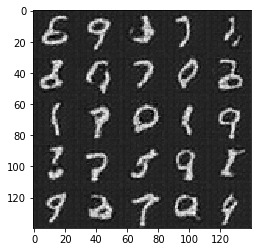

Epoch 2/2... Discriminator Loss: 1.0735... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 0.5182... Generator Loss: 1.5745
Epoch 2/2... Discriminator Loss: 0.6363... Generator Loss: 1.0640
Epoch 2/2... Discriminator Loss: 0.5778... Generator Loss: 1.0679
Epoch 2/2... Discriminator Loss: 0.4029... Generator Loss: 1.6307
Epoch 2/2... Discriminator Loss: 0.0766... Generator Loss: 5.9111
Epoch 2/2... Discriminator Loss: 0.2382... Generator Loss: 2.5265
Epoch 2/2... Discriminator Loss: 0.0802... Generator Loss: 4.0698
Epoch 2/2... Discriminator Loss: 0.1088... Generator Loss: 5.1480
Epoch 2/2... Discriminator Loss: 4.2522... Generator Loss: 9.0062


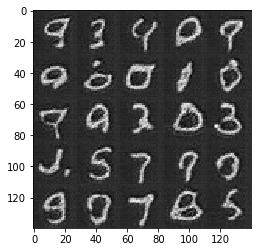

Epoch 2/2... Discriminator Loss: 0.2623... Generator Loss: 1.9852
Epoch 2/2... Discriminator Loss: 0.5241... Generator Loss: 2.5181
Epoch 2/2... Discriminator Loss: 0.3121... Generator Loss: 2.6529
Epoch 2/2... Discriminator Loss: 0.1205... Generator Loss: 3.3516
Epoch 2/2... Discriminator Loss: 0.4028... Generator Loss: 1.4695
Epoch 2/2... Discriminator Loss: 0.1131... Generator Loss: 3.0826
Epoch 2/2... Discriminator Loss: 0.1257... Generator Loss: 3.0881
Epoch 2/2... Discriminator Loss: 0.1849... Generator Loss: 2.4982
Epoch 2/2... Discriminator Loss: 1.0553... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 0.5745... Generator Loss: 1.6009


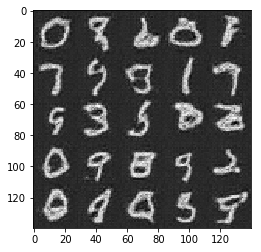

Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 1.5670
Epoch 2/2... Discriminator Loss: 0.5774... Generator Loss: 1.3628
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 0.3034... Generator Loss: 1.7891
Epoch 2/2... Discriminator Loss: 0.8257... Generator Loss: 1.1537
Epoch 2/2... Discriminator Loss: 0.3155... Generator Loss: 2.2689
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.2611
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 0.8288
Epoch 2/2... Discriminator Loss: 0.2599... Generator Loss: 2.6702
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.1866


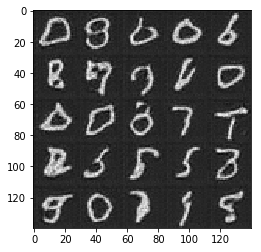

Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 0.5848
Epoch 2/2... Discriminator Loss: 0.2123... Generator Loss: 2.8909
Epoch 2/2... Discriminator Loss: 0.2691... Generator Loss: 2.9382
Epoch 2/2... Discriminator Loss: 1.2894... Generator Loss: 0.4630
Epoch 2/2... Discriminator Loss: 0.6035... Generator Loss: 1.3354
Epoch 2/2... Discriminator Loss: 0.5869... Generator Loss: 1.2910
Epoch 2/2... Discriminator Loss: 0.3247... Generator Loss: 2.5019
Epoch 2/2... Discriminator Loss: 1.4205... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 0.5867... Generator Loss: 1.3373
Epoch 2/2... Discriminator Loss: 0.4879... Generator Loss: 1.6073


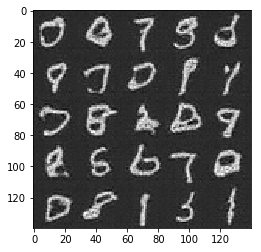

Epoch 2/2... Discriminator Loss: 0.3901... Generator Loss: 1.6777
Epoch 2/2... Discriminator Loss: 1.2622... Generator Loss: 0.4242
Epoch 2/2... Discriminator Loss: 0.4455... Generator Loss: 1.3209
Epoch 2/2... Discriminator Loss: 0.2213... Generator Loss: 2.3484
Epoch 2/2... Discriminator Loss: 0.2757... Generator Loss: 2.0925
Epoch 2/2... Discriminator Loss: 0.1418... Generator Loss: 3.8417
Epoch 2/2... Discriminator Loss: 0.4648... Generator Loss: 1.2113
Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 1.4229
Epoch 2/2... Discriminator Loss: 0.5493... Generator Loss: 1.4560
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 0.6519


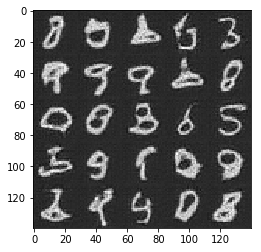

Epoch 2/2... Discriminator Loss: 0.5205... Generator Loss: 1.7118
Epoch 2/2... Discriminator Loss: 0.9070... Generator Loss: 0.5647
Epoch 2/2... Discriminator Loss: 0.7867... Generator Loss: 0.9586
Epoch 2/2... Discriminator Loss: 0.2894... Generator Loss: 1.8901
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 3.0903
Epoch 2/2... Discriminator Loss: 0.5699... Generator Loss: 1.2865
Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 1.0586
Epoch 2/2... Discriminator Loss: 0.3139... Generator Loss: 2.1479
Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 0.9284
Epoch 2/2... Discriminator Loss: 0.4085... Generator Loss: 2.1868


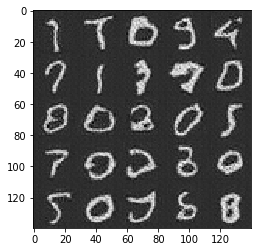

Epoch 2/2... Discriminator Loss: 0.4863... Generator Loss: 1.4244
Epoch 2/2... Discriminator Loss: 0.5736... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 0.0893... Generator Loss: 4.1240
Epoch 2/2... Discriminator Loss: 0.3971... Generator Loss: 1.5376
Epoch 2/2... Discriminator Loss: 1.2552... Generator Loss: 0.6428
Epoch 2/2... Discriminator Loss: 0.5791... Generator Loss: 1.9057
Epoch 2/2... Discriminator Loss: 1.5019... Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 1.8796
Epoch 2/2... Discriminator Loss: 0.6614... Generator Loss: 1.0053


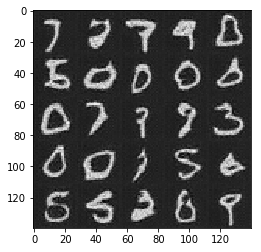

Epoch 2/2... Discriminator Loss: 0.5539... Generator Loss: 1.2810
Epoch 2/2... Discriminator Loss: 0.6735... Generator Loss: 1.1494
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 1.8007
Epoch 2/2... Discriminator Loss: 0.3250... Generator Loss: 1.8217
Epoch 2/2... Discriminator Loss: 0.9165... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 0.7475


In [27]:
batch_size = 64
z_dim = 100
learning_rate =  0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
        

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 0.4725... Generator Loss: 6.5661
Epoch 1/1... Discriminator Loss: 0.5218... Generator Loss: 3.5455
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 2.7306
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 2.3217
Epoch 1/1... Discriminator Loss: 0.4631... Generator Loss: 2.6995
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 3.0954
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 3.2906
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 2.0270


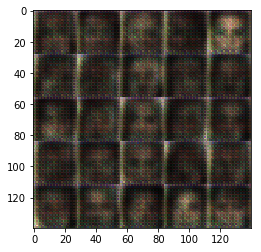

Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 3.4257
Epoch 1/1... Discriminator Loss: 0.7342... Generator Loss: 1.6226
Epoch 1/1... Discriminator Loss: 0.4455... Generator Loss: 3.4662
Epoch 1/1... Discriminator Loss: 0.6492... Generator Loss: 3.7246
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 0.4159... Generator Loss: 2.3963
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 2.3561
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 2.9293
Epoch 1/1... Discriminator Loss: 0.5368... Generator Loss: 1.6904
Epoch 1/1... Discriminator Loss: 0.2795... Generator Loss: 3.8170


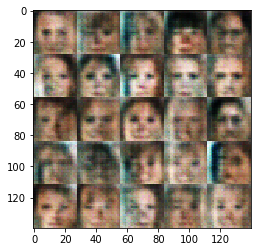

Epoch 1/1... Discriminator Loss: 0.6473... Generator Loss: 5.2698
Epoch 1/1... Discriminator Loss: 0.1664... Generator Loss: 4.3091
Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 4.7608
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 6.8662
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.1050
Epoch 1/1... Discriminator Loss: 0.2353... Generator Loss: 3.8338
Epoch 1/1... Discriminator Loss: 0.1065... Generator Loss: 5.1727
Epoch 1/1... Discriminator Loss: 0.2747... Generator Loss: 4.1673
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 4.8547


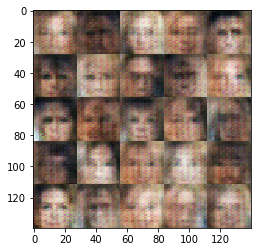

Epoch 1/1... Discriminator Loss: 0.1459... Generator Loss: 4.2130
Epoch 1/1... Discriminator Loss: 0.0745... Generator Loss: 4.0985
Epoch 1/1... Discriminator Loss: 0.1347... Generator Loss: 3.2319
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 1.9778
Epoch 1/1... Discriminator Loss: 0.3817... Generator Loss: 10.2812
Epoch 1/1... Discriminator Loss: 0.3299... Generator Loss: 3.3986
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 10.1094
Epoch 1/1... Discriminator Loss: 0.6619... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 0.0936... Generator Loss: 9.1947
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.1648


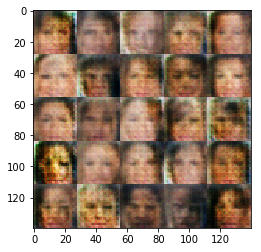

Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 9.3464
Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 10.2152
Epoch 1/1... Discriminator Loss: 0.2568... Generator Loss: 2.4447
Epoch 1/1... Discriminator Loss: 0.1563... Generator Loss: 2.7112
Epoch 1/1... Discriminator Loss: 0.1866... Generator Loss: 2.5534
Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 5.9137
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 10.1201
Epoch 1/1... Discriminator Loss: 0.0502... Generator Loss: 5.7356
Epoch 1/1... Discriminator Loss: 0.2316... Generator Loss: 7.7977
Epoch 1/1... Discriminator Loss: 0.0368... Generator Loss: 5.6909


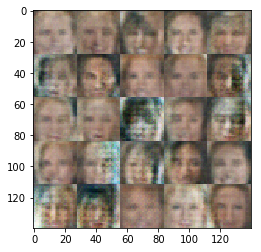

Epoch 1/1... Discriminator Loss: 0.0523... Generator Loss: 8.3107
Epoch 1/1... Discriminator Loss: 0.1605... Generator Loss: 5.9050
Epoch 1/1... Discriminator Loss: 0.0284... Generator Loss: 5.5186
Epoch 1/1... Discriminator Loss: 0.0397... Generator Loss: 6.3043
Epoch 1/1... Discriminator Loss: 0.0072... Generator Loss: 6.8764
Epoch 1/1... Discriminator Loss: 0.0256... Generator Loss: 4.8593
Epoch 1/1... Discriminator Loss: 0.0194... Generator Loss: 7.3921
Epoch 1/1... Discriminator Loss: 0.1294... Generator Loss: 8.5293
Epoch 1/1... Discriminator Loss: 0.0078... Generator Loss: 9.3725
Epoch 1/1... Discriminator Loss: 0.0538... Generator Loss: 4.4692


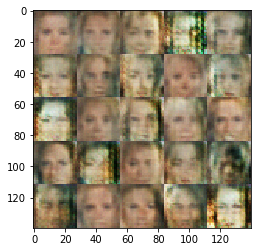

Epoch 1/1... Discriminator Loss: 0.0701... Generator Loss: 3.6882
Epoch 1/1... Discriminator Loss: 1.6500... Generator Loss: 8.0144
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 8.1999
Epoch 1/1... Discriminator Loss: 0.2767... Generator Loss: 4.1131
Epoch 1/1... Discriminator Loss: 0.0846... Generator Loss: 4.7569
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 0.3874... Generator Loss: 4.2432
Epoch 1/1... Discriminator Loss: 0.3701... Generator Loss: 4.2679
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 8.6629
Epoch 1/1... Discriminator Loss: 0.1666... Generator Loss: 4.8193


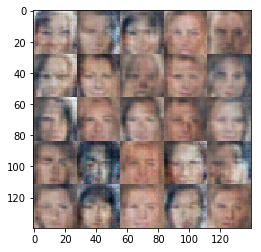

Epoch 1/1... Discriminator Loss: 0.0782... Generator Loss: 8.1271
Epoch 1/1... Discriminator Loss: 0.0952... Generator Loss: 2.9643
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 6.6254
Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 6.1044
Epoch 1/1... Discriminator Loss: 0.0724... Generator Loss: 3.7744
Epoch 1/1... Discriminator Loss: 1.8195... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 2.7153
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 0.2212... Generator Loss: 4.8480
Epoch 1/1... Discriminator Loss: 0.3449... Generator Loss: 7.1125


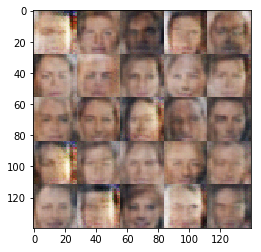

Epoch 1/1... Discriminator Loss: 0.1953... Generator Loss: 2.8466
Epoch 1/1... Discriminator Loss: 0.2211... Generator Loss: 7.7100
Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 4.5267
Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 9.0740
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 3.9940
Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 8.4964
Epoch 1/1... Discriminator Loss: 0.1956... Generator Loss: 2.8059
Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 2.7626
Epoch 1/1... Discriminator Loss: 0.0448... Generator Loss: 4.2380
Epoch 1/1... Discriminator Loss: 0.0437... Generator Loss: 6.9274


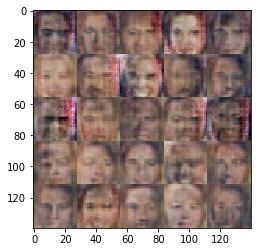

Epoch 1/1... Discriminator Loss: 0.0097... Generator Loss: 6.6125
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 8.6585
Epoch 1/1... Discriminator Loss: 0.0415... Generator Loss: 6.9829
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 6.5622
Epoch 1/1... Discriminator Loss: 2.0174... Generator Loss: 9.0626
Epoch 1/1... Discriminator Loss: 0.8757... Generator Loss: 5.2376
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 2.1251
Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 7.4396


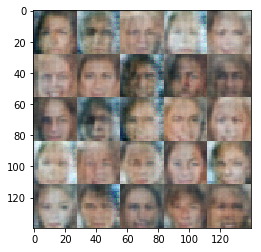

Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.1846
Epoch 1/1... Discriminator Loss: 0.3502... Generator Loss: 4.7288
Epoch 1/1... Discriminator Loss: 0.3913... Generator Loss: 2.8349
Epoch 1/1... Discriminator Loss: 0.1435... Generator Loss: 4.4174
Epoch 1/1... Discriminator Loss: 0.4910... Generator Loss: 1.7793
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 7.9926
Epoch 1/1... Discriminator Loss: 0.0982... Generator Loss: 4.9256
Epoch 1/1... Discriminator Loss: 0.1773... Generator Loss: 2.4154
Epoch 1/1... Discriminator Loss: 0.1757... Generator Loss: 5.1521
Epoch 1/1... Discriminator Loss: 0.3744... Generator Loss: 1.5937


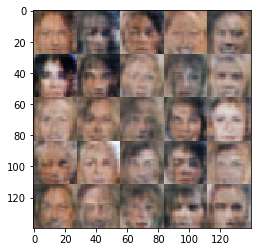

Epoch 1/1... Discriminator Loss: 0.1295... Generator Loss: 9.1423
Epoch 1/1... Discriminator Loss: 0.0229... Generator Loss: 5.9200
Epoch 1/1... Discriminator Loss: 0.0900... Generator Loss: 4.0425
Epoch 1/1... Discriminator Loss: 0.1242... Generator Loss: 3.9283
Epoch 1/1... Discriminator Loss: 0.2087... Generator Loss: 2.8804
Epoch 1/1... Discriminator Loss: 0.1721... Generator Loss: 9.3168
Epoch 1/1... Discriminator Loss: 0.2216... Generator Loss: 7.2563
Epoch 1/1... Discriminator Loss: 0.3736... Generator Loss: 10.3474
Epoch 1/1... Discriminator Loss: 0.0667... Generator Loss: 4.5081
Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 6.9346


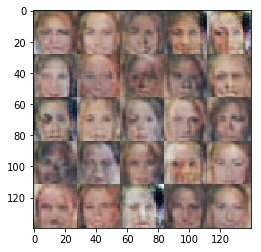

Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 4.5881
Epoch 1/1... Discriminator Loss: 0.1737... Generator Loss: 2.6870
Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 5.0695
Epoch 1/1... Discriminator Loss: 0.1042... Generator Loss: 3.4845
Epoch 1/1... Discriminator Loss: 0.2973... Generator Loss: 2.0218
Epoch 1/1... Discriminator Loss: 2.1220... Generator Loss: 7.3788
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.7886
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 2.1038
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 2.3041
Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.8762


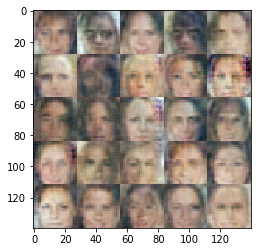

Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 3.1617
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.8983
Epoch 1/1... Discriminator Loss: 0.3730... Generator Loss: 4.5364
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 2.0629
Epoch 1/1... Discriminator Loss: 0.4715... Generator Loss: 5.0631
Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.3156
Epoch 1/1... Discriminator Loss: 0.6768... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 0.2477... Generator Loss: 3.1186
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 4.7129
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 10.7256


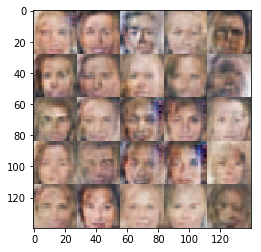

Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 4.0074
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 2.1415
Epoch 1/1... Discriminator Loss: 0.3497... Generator Loss: 3.1727
Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 2.1066
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 1.0866
Epoch 1/1... Discriminator Loss: 0.1941... Generator Loss: 3.2227
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 2.3242
Epoch 1/1... Discriminator Loss: 0.1241... Generator Loss: 3.4073
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 5.9149


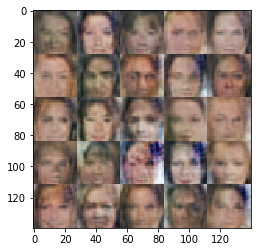

Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 4.2861
Epoch 1/1... Discriminator Loss: 0.4350... Generator Loss: 5.2914
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 0.4295... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 0.1831... Generator Loss: 2.5289
Epoch 1/1... Discriminator Loss: 0.1596... Generator Loss: 3.3098
Epoch 1/1... Discriminator Loss: 0.4497... Generator Loss: 2.1727
Epoch 1/1... Discriminator Loss: 0.1433... Generator Loss: 3.4594
Epoch 1/1... Discriminator Loss: 0.0890... Generator Loss: 3.7251
Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 3.2240


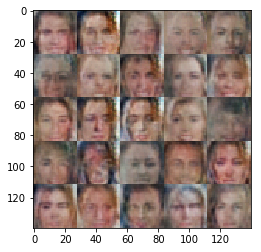

Epoch 1/1... Discriminator Loss: 0.2773... Generator Loss: 6.5389
Epoch 1/1... Discriminator Loss: 0.1398... Generator Loss: 4.1352
Epoch 1/1... Discriminator Loss: 0.5590... Generator Loss: 1.3844
Epoch 1/1... Discriminator Loss: 0.2835... Generator Loss: 2.1182
Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 4.0719
Epoch 1/1... Discriminator Loss: 0.1819... Generator Loss: 3.1954
Epoch 1/1... Discriminator Loss: 0.8464... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 0.1366... Generator Loss: 2.8363
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.6328
Epoch 1/1... Discriminator Loss: 0.5939... Generator Loss: 2.2583


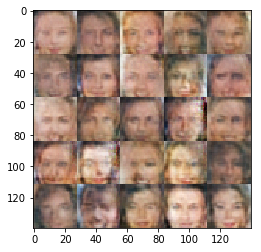

Epoch 1/1... Discriminator Loss: 0.3722... Generator Loss: 5.7197
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 6.2318
Epoch 1/1... Discriminator Loss: 0.3508... Generator Loss: 2.0489
Epoch 1/1... Discriminator Loss: 0.2266... Generator Loss: 6.4073
Epoch 1/1... Discriminator Loss: 0.2280... Generator Loss: 8.7875
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 6.1880
Epoch 1/1... Discriminator Loss: 0.0916... Generator Loss: 5.0962
Epoch 1/1... Discriminator Loss: 0.0789... Generator Loss: 4.3945
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 9.0364
Epoch 1/1... Discriminator Loss: 0.1412... Generator Loss: 8.4501


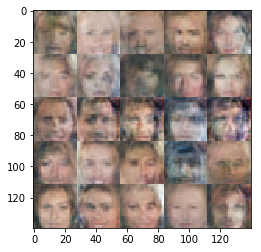

Epoch 1/1... Discriminator Loss: 0.1476... Generator Loss: 5.9353
Epoch 1/1... Discriminator Loss: 0.4523... Generator Loss: 1.5711
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 3.7900
Epoch 1/1... Discriminator Loss: 0.1097... Generator Loss: 5.0730
Epoch 1/1... Discriminator Loss: 0.8317... Generator Loss: 7.9450
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 2.0293
Epoch 1/1... Discriminator Loss: 0.1466... Generator Loss: 2.9576
Epoch 1/1... Discriminator Loss: 0.8001... Generator Loss: 9.8318
Epoch 1/1... Discriminator Loss: 0.2434... Generator Loss: 4.3143
Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 3.9486


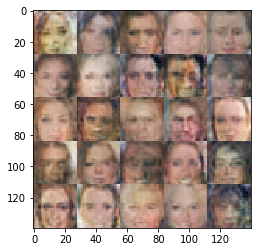

Epoch 1/1... Discriminator Loss: 0.1094... Generator Loss: 2.9528
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 8.1604
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 2.5680
Epoch 1/1... Discriminator Loss: 0.6858... Generator Loss: 3.6648
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 0.4860... Generator Loss: 3.2871
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 1.9807
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.0157
Epoch 1/1... Discriminator Loss: 0.2398... Generator Loss: 3.7603
Epoch 1/1... Discriminator Loss: 0.0986... Generator Loss: 6.1600


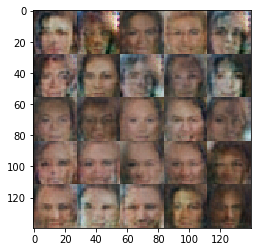

Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 3.3113
Epoch 1/1... Discriminator Loss: 0.4535... Generator Loss: 1.5751
Epoch 1/1... Discriminator Loss: 0.4772... Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.2020... Generator Loss: 4.1942
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 0.1639... Generator Loss: 3.0965
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 0.1862... Generator Loss: 2.9090
Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 7.5450
Epoch 1/1... Discriminator Loss: 0.0609... Generator Loss: 9.4957


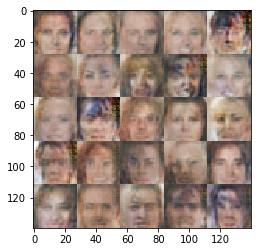

Epoch 1/1... Discriminator Loss: 0.0710... Generator Loss: 5.3749
Epoch 1/1... Discriminator Loss: 0.6496... Generator Loss: 7.2835
Epoch 1/1... Discriminator Loss: 0.0366... Generator Loss: 6.4738
Epoch 1/1... Discriminator Loss: 0.1930... Generator Loss: 3.0488
Epoch 1/1... Discriminator Loss: 0.2197... Generator Loss: 5.8083
Epoch 1/1... Discriminator Loss: 0.3225... Generator Loss: 3.6446
Epoch 1/1... Discriminator Loss: 0.2550... Generator Loss: 3.0256
Epoch 1/1... Discriminator Loss: 0.5393... Generator Loss: 7.9820
Epoch 1/1... Discriminator Loss: 0.2492... Generator Loss: 3.1106
Epoch 1/1... Discriminator Loss: 0.0744... Generator Loss: 4.3733


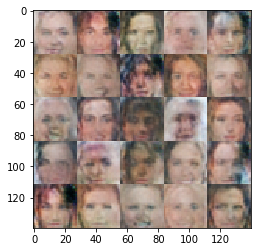

Epoch 1/1... Discriminator Loss: 0.1563... Generator Loss: 2.6419
Epoch 1/1... Discriminator Loss: 0.1134... Generator Loss: 3.8226
Epoch 1/1... Discriminator Loss: 0.0913... Generator Loss: 7.6468
Epoch 1/1... Discriminator Loss: 0.0317... Generator Loss: 7.2034
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 5.4212
Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 1.9643
Epoch 1/1... Discriminator Loss: 0.1450... Generator Loss: 3.3527
Epoch 1/1... Discriminator Loss: 0.0364... Generator Loss: 6.3267
Epoch 1/1... Discriminator Loss: 0.0191... Generator Loss: 6.6099
Epoch 1/1... Discriminator Loss: 0.0247... Generator Loss: 8.3739


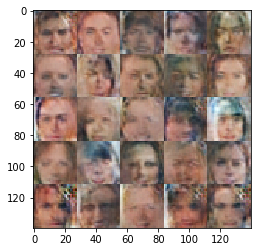

Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 1.8259
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 9.1567
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 4.4136
Epoch 1/1... Discriminator Loss: 0.0937... Generator Loss: 3.8255
Epoch 1/1... Discriminator Loss: 0.0494... Generator Loss: 5.5102
Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 4.6556
Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 7.9864
Epoch 1/1... Discriminator Loss: 0.3088... Generator Loss: 11.6304
Epoch 1/1... Discriminator Loss: 0.1717... Generator Loss: 3.9128
Epoch 1/1... Discriminator Loss: 0.2753... Generator Loss: 2.8650


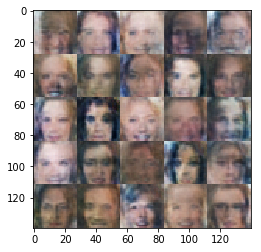

Epoch 1/1... Discriminator Loss: 0.1823... Generator Loss: 2.4661
Epoch 1/1... Discriminator Loss: 0.2597... Generator Loss: 7.9248
Epoch 1/1... Discriminator Loss: 0.0533... Generator Loss: 7.1173
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 0.4780... Generator Loss: 3.0362
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 6.4698
Epoch 1/1... Discriminator Loss: 0.7707... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 0.1324... Generator Loss: 3.3192
Epoch 1/1... Discriminator Loss: 0.1579... Generator Loss: 3.3744
Epoch 1/1... Discriminator Loss: 0.2228... Generator Loss: 6.0172


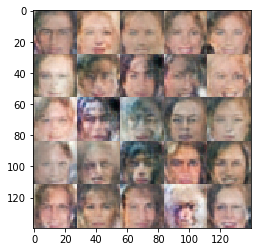

Epoch 1/1... Discriminator Loss: 0.1938... Generator Loss: 2.4719
Epoch 1/1... Discriminator Loss: 0.0384... Generator Loss: 6.1818
Epoch 1/1... Discriminator Loss: 0.0473... Generator Loss: 9.6919
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 7.4195
Epoch 1/1... Discriminator Loss: 0.1601... Generator Loss: 2.8120
Epoch 1/1... Discriminator Loss: 0.0557... Generator Loss: 4.6292
Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 5.3278
Epoch 1/1... Discriminator Loss: 0.1338... Generator Loss: 5.3144
Epoch 1/1... Discriminator Loss: 0.0610... Generator Loss: 3.6649
Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 8.4437


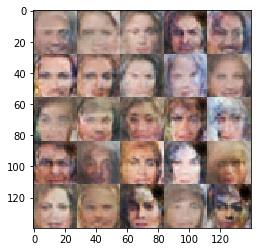

Epoch 1/1... Discriminator Loss: 0.1235... Generator Loss: 3.4652
Epoch 1/1... Discriminator Loss: 0.0189... Generator Loss: 5.8070
Epoch 1/1... Discriminator Loss: 0.1179... Generator Loss: 3.9820
Epoch 1/1... Discriminator Loss: 0.0187... Generator Loss: 10.8300
Epoch 1/1... Discriminator Loss: 0.0828... Generator Loss: 4.1497
Epoch 1/1... Discriminator Loss: 0.3860... Generator Loss: 1.9056
Epoch 1/1... Discriminator Loss: 0.0362... Generator Loss: 6.9493
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 7.0255
Epoch 1/1... Discriminator Loss: 0.0321... Generator Loss: 9.1613
Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 6.6323


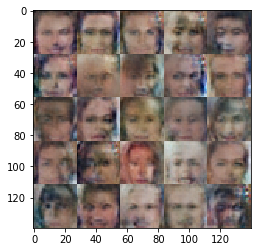

Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 2.4870
Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 2.5927
Epoch 1/1... Discriminator Loss: 0.1176... Generator Loss: 3.3851
Epoch 1/1... Discriminator Loss: 0.0317... Generator Loss: 5.5660
Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 8.2922
Epoch 1/1... Discriminator Loss: 0.0568... Generator Loss: 5.8057
Epoch 1/1... Discriminator Loss: 0.3981... Generator Loss: 1.7508
Epoch 1/1... Discriminator Loss: 0.2777... Generator Loss: 5.7933
Epoch 1/1... Discriminator Loss: 0.0413... Generator Loss: 5.3403
Epoch 1/1... Discriminator Loss: 0.0290... Generator Loss: 6.4434


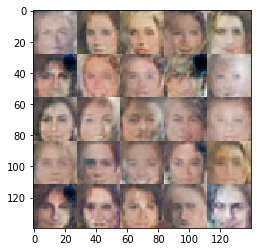

Epoch 1/1... Discriminator Loss: 0.0776... Generator Loss: 3.7448
Epoch 1/1... Discriminator Loss: 0.0903... Generator Loss: 7.4571
Epoch 1/1... Discriminator Loss: 0.2186... Generator Loss: 2.3624
Epoch 1/1... Discriminator Loss: 0.1397... Generator Loss: 2.9126
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 7.0436
Epoch 1/1... Discriminator Loss: 0.1364... Generator Loss: 5.3792
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 8.8202
Epoch 1/1... Discriminator Loss: 0.2403... Generator Loss: 2.6942
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.0296
Epoch 1/1... Discriminator Loss: 0.1662... Generator Loss: 4.5956


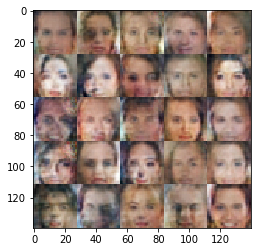

Epoch 1/1... Discriminator Loss: 0.1446... Generator Loss: 4.0668
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 0.1138... Generator Loss: 4.3362
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 6.8171
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 9.0043
Epoch 1/1... Discriminator Loss: 0.1867... Generator Loss: 7.0075
Epoch 1/1... Discriminator Loss: 0.0485... Generator Loss: 4.7713
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 3.0614
Epoch 1/1... Discriminator Loss: 0.0280... Generator Loss: 6.2893
Epoch 1/1... Discriminator Loss: 0.0536... Generator Loss: 4.8563


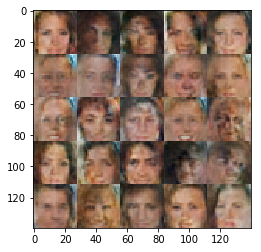

Epoch 1/1... Discriminator Loss: 0.0124... Generator Loss: 6.7696
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 5.5990
Epoch 1/1... Discriminator Loss: 0.0729... Generator Loss: 5.7967
Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 3.5055
Epoch 1/1... Discriminator Loss: 0.0410... Generator Loss: 10.0226
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 6.4694
Epoch 1/1... Discriminator Loss: 0.0157... Generator Loss: 6.2660
Epoch 1/1... Discriminator Loss: 0.1392... Generator Loss: 2.9355
Epoch 1/1... Discriminator Loss: 0.6528... Generator Loss: 1.3215
Epoch 1/1... Discriminator Loss: 0.1031... Generator Loss: 3.8599


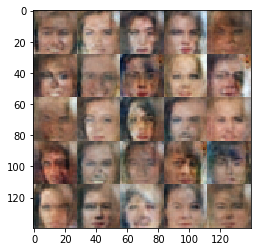

Epoch 1/1... Discriminator Loss: 0.1868... Generator Loss: 7.9110
Epoch 1/1... Discriminator Loss: 0.7504... Generator Loss: 1.5661
Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 8.3904
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 7.1887
Epoch 1/1... Discriminator Loss: 0.1489... Generator Loss: 3.3415
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 1.7866


In [61]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.